In [1]:
%%capture

!git clone https://huggingface.co/datasets/Djulo/Wider_FaceSegLite data/

In [2]:
import os
import cv2
import time
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

from skimage.draw import polygon
from skimage import io, transform
from sklearn.metrics import jaccard_score

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from torch.nn import ConvTranspose2d
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Module
from torch.nn import ModuleList
from torch.nn import ReLU
from torchvision.transforms import CenterCrop
from torch.nn import functional as F

In [3]:
def load_yolo_format(file_path):
  """
  Loads a file in YOLO format and pads coordinates with zeros.

  Args:
    - file_path: path to the file to load.
  Returns:
    - objects: np array of objects in the image. Each object is represented as a
      tuple of (x1, y1, ..., xn, yn), padded with zeros if necessary.
  """
  with open(file_path, 'r') as f:
    lines = f.readlines()

  objects = []
  for line in lines:
    data = line.strip().split()
    class_index = int(data[0]) # We don't care about the class name because we work only with one class (face)
    coordinates = np.array(list(map(float, data[1:])))
    objects.append(coordinates)

  return objects

def segments_to_masks(normalized_segments, image_shape):
    """
    Convert multiple normalized segments to a labeled mask.

    Args:
        normalized_segments (list): List of normalized segments.
        image_shape (tuple): Shape of the original image.

    Returns:
        mask (torch.Tensor): Labeled mask with shape (1, h, w).
    """
    mask = np.zeros(image_shape, dtype=np.int32)

    for i, segment in enumerate(normalized_segments):
        coords = np.array(segment).reshape(-1, 2)

        # Convert normalized coordinates back to original image coordinates
        coords[:, 0] *= image_shape[1]  # width
        coords[:, 1] *= image_shape[0]  # height

        # Ensure coordinates are within the image boundaries
        coords[:, 0] = np.clip(coords[:, 0], 0, image_shape[1] - 1)
        coords[:, 1] = np.clip(coords[:, 1], 0, image_shape[0] - 1)

        # Round to integers
        coords = np.round(coords).astype(int)

        # Create a polygon and fill it in the mask
        rr, cc = polygon(coords[:, 1], coords[:, 0], shape=image_shape)
        mask[rr, cc] = 1

    return mask[np.newaxis, ...]

def found_directory(file_path, folders):
    """
    Finds the directory in which the file is located.

    Args:
        - file_path: path to the file to load.
        - folders: list of folders to look into.

    Returns:
        - folder: name of the folder in which the file is located.
    """
    for i, folder in enumerate(folders):
        file_id = file_path.split('_')[0]
        folder_id = folder.split('--')[0]
        if file_id == folder_id:
            return folders[i]
    raise ValueError(f"Folder {folders} not found in {file_path}")

In [4]:
class FslDataset(Dataset):
    def __init__(self, root_dir, transforms=None):
        self.root_dir = root_dir
        self.transforms = transforms

        # Get the mask files
        self.mask_folder = os.path.join(root_dir, 'masks')
        self.mask_files = sorted(os.listdir(self.mask_folder))

        # Get the image files
        self.image_folder = os.path.join(root_dir, 'images')
        self.image_files = [os.path.join(self.image_folder, found_directory(file_path, os.listdir(self.image_folder)),
                file_path.replace('txt', 'jpg')) for file_path in self.mask_files]

    def __len__(self):
        return len(self.mask_files)


    def __getitem__(self, idx):
        # Get the image
        image = cv2.imread(self.image_files[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Get mask
        mask_path = os.path.join(self.mask_folder, self.mask_files[idx])
        mask_yolo = load_yolo_format(mask_path)
        mask = segments_to_masks(mask_yolo, image.shape[:-1])
        mask = np.transpose(mask, (1, 2, 0))

        if self.transforms:
            image = self.transforms(image)
            mask = self.transforms(mask)
        return (image, mask)

In [5]:
DATA_PATH="/kaggle/working/"

# Define the portion of training data
TEST_SPLIT = 0.8

NUM_CHANNELS = 1
NUM_CLASSES = 1
NUM_LEVELS = 3

# initialize learning rate, number of epochs to train for, and the
# batch size
INIT_LR = 0.001
NUM_EPOCHS = 50
BATCH_SIZE = 64

# define the input image dimensions
INPUT_IMAGE_WIDTH = 256
INPUT_IMAGE_HEIGHT = 256

# define threshold to filter weak predictions
THRESHOLD = 0.1

# define the path to save the models
MODEL_SAVED_PATH = "/kaggle/working/"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device: {DEVICE}")

device: cuda


In [6]:
transforms = transforms.Compose([transforms.ToPILImage(),
                                 transforms.Resize((INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH)),
                                 transforms.ToTensor()])


fsl_dataset = FslDataset(root_dir=f'{DATA_PATH}data/', transforms=transforms)

split = len(fsl_dataset) - int(len(fsl_dataset) * TEST_SPLIT)
indices = torch.randperm(len(fsl_dataset)).tolist()
dataset_train = torch.utils.data.Subset(fsl_dataset, indices[:-split])
dataset_test = torch.utils.data.Subset(fsl_dataset, indices[-split:])

# define training and validation data loaders
train_loader = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=64,
    shuffle=True,
    num_workers=4,
)

test_loader = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=64,
    shuffle=False,
    num_workers=4,
)

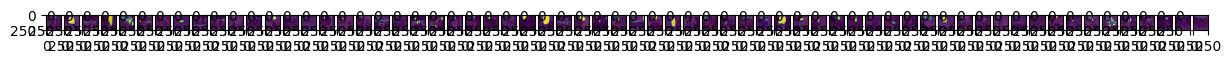

In [7]:
for batch_idx, batch in enumerate(train_loader):
    if batch_idx == 1:
        break

    plt.figure(figsize=(15,10))
    # Iterate through samples in the batch
    for i in range(len(batch[0])):
        sample = (batch[0][i], batch[1][i])

        #print(f"Sample image {sample[0].shape}")
        #print(f"Sample mask {sample[1].shape}")
        plt.subplot(1, len(batch[0]), i + 1)
        plt.imshow(sample[0].permute(1, 2, 0))

        for mask in sample[1]:
            if mask.sum() == 0:
                continue

            plt.imshow(mask, alpha=0.8)
    plt.show()

In [8]:
class Block(Module):
    def __init__(self, inChannels, outChannels):
        super().__init__()
        # store the convolution and RELU layers
        self.conv1 = Conv2d(inChannels, outChannels, 3)
        self.relu = ReLU()
        self.conv2 = Conv2d(outChannels, outChannels, 3)
    def forward(self, x):
        # apply CONV => RELU => CONV block to the inputs and return it
        return self.conv2(self.relu(self.conv1(x)))

class Encoder(Module):
    def __init__(self, channels=(3, 16, 32, 64)):
        super().__init__()
        # store the encoder blocks and maxpooling layer
        self.encBlocks = ModuleList(
            [Block(channels[i], channels[i + 1])
                for i in range(len(channels) - 1)])
        self.pool = MaxPool2d(2)
    def forward(self, x):
        # initialize an empty list to store the intermediate outputs
        blockOutputs = []
        # loop through the encoder blocks
        for block in self.encBlocks:
            # pass the inputs through the current encoder block, store
            # the outputs, and then apply maxpooling on the output
            x = block(x)
            blockOutputs.append(x)
            x = self.pool(x)
        # return the list containing the intermediate outputs
        return blockOutputs


class Decoder(Module):
    def __init__(self, channels=(64, 32, 16)):
        super().__init__()
        # initialize the number of channels, upsampler blocks, and
        # decoder blocks
        self.channels = channels
        self.upconvs = ModuleList(
            [ConvTranspose2d(channels[i], channels[i + 1], 2, 2)
                for i in range(len(channels) - 1)])
        self.dec_blocks = ModuleList(
            [Block(channels[i], channels[i + 1])
                for i in range(len(channels) - 1)])
    def forward(self, x, encFeatures):
        # loop through the number of channels
        for i in range(len(self.channels) - 1):
            # pass the inputs through the upsampler blocks
            x = self.upconvs[i](x)
            # crop the current features from the encoder blocks,
            # concatenate them with the current upsampled features,
            # and pass the concatenated output through the current
            # decoder block
            encFeat = self.crop(encFeatures[i], x)
            x = torch.cat([x, encFeat], dim=1)
            x = self.dec_blocks[i](x)
        # return the final decoder output
        return x
    def crop(self, encFeatures, x):
        # grab the dimensions of the inputs, and crop the encoder
        # features to match the dimensions
        (_, _, H, W) = x.shape
        encFeatures = CenterCrop([H, W])(encFeatures)
        # return the cropped features
        return encFeatures

In [9]:
class UNet(Module):
    def __init__(self, encChannels=(3, 16, 32, 64), decChannels=(64, 32, 16), nbClasses=1, retainDim=True, outSize=(INPUT_IMAGE_HEIGHT,  INPUT_IMAGE_WIDTH)):
        super().__init__()
        # initialize the encoder and decoder
        self.encoder = Encoder(encChannels)
        self.decoder = Decoder(decChannels)
        # initialize the regression head and store the class variables
        self.head = Conv2d(decChannels[-1], nbClasses, 1)
        self.retainDim = retainDim
        self.outSize = outSize    

    def forward(self, x):
      # grab the features from the encoder
      encFeatures = self.encoder(x)
      # pass the encoder features through decoder making sure that
      # their dimensions are suited for concatenation
      decFeatures = self.decoder(encFeatures[::-1][0],
        encFeatures[::-1][1:])
      # pass the decoder features through the regression head to
      # obtain the segmentation mask
      map = self.head(decFeatures)
      # check to see if we are retaining the original output
      # dimensions and if so, then resize the output to match them
      if self.retainDim:
        map = F.interpolate(map, self.outSize)
      # return the segmentation map
      return map     


In [10]:
def print_model_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Number of parameters in the model: {total_params}")

unet = UNet(nbClasses=1).to(DEVICE)
print_model_parameters(unet)

Number of parameters in the model: 117041


In [11]:
# initialize loss function and optimizer
lossFunc = BCEWithLogitsLoss()
opt = Adam(unet.parameters(), lr=INIT_LR)

# calculate steps per epoch for training and test set
trainSteps = len(dataset_train) // BATCH_SIZE
testSteps = len(dataset_test) // BATCH_SIZE

# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": [], "iou": []}

In [12]:

print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(NUM_EPOCHS)):
    unet.train()
    
    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalTestLoss = 0

    for (i, (x, y)) in enumerate(train_loader):
   
      # send the input to the device
      (x, y) = (x.to(DEVICE), y.to(DEVICE))
      # perform a forward pass and calculate the training loss
      pred = unet(x)
      loss = lossFunc(pred, y.float())
      # first, zero out any previously accumulated gradients, then
      # perform backpropagation, and then update model parameters
      opt.zero_grad()
      loss.backward()
      opt.step()
      # add the loss to the total training loss so far
      totalTrainLoss += loss
    
    with torch.no_grad():
      # set the model in evaluation mode
      unet.eval()
      # loop over the validation set
      for (x, y) in test_loader:
      
        # send the input to the device
        (x, y) = (x.to(DEVICE), y.to(DEVICE))
        # make the predictions and calculate the validation loss
        pred = unet(x)
        totalTestLoss += lossFunc(pred, y.float())
        
           # convert predictions and ground truth to binary masks
        pred_binary = (torch.sigmoid(pred) > THRESHOLD).float()
        y_binary = y.float()

        # calculate IoU (Jaccard Score)
        iou = jaccard_score(y_binary.view(-1).cpu().numpy(), pred_binary.view(-1).cpu().numpy(), average='binary')
        
    # calculate the average training and validation loss
    avgTrainLoss = totalTrainLoss / trainSteps
    avgTestLoss = totalTestLoss / testSteps
    
    # update our training history
    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["test_loss"].append(avgTestLoss.cpu().detach().numpy())
    H["iou"].append(iou)

    # print the model training and validation information
    print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
    print("Train loss: {:.6f}, Test loss: {:.4f}, IoU: {:.4f}".format(
        avgTrainLoss, avgTestLoss, iou))

    #if (e + 1) % 10 == 0:
    torch.save(unet.state_dict(), f'{MODEL_SAVED_PATH}unet_epoch_{e}.pt')

# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
    endTime - startTime))

[INFO] training the network...


  2%|▏         | 1/50 [01:39<1:21:11, 99.41s/it]

[INFO] EPOCH: 1/50
Train loss: 0.303999, Test loss: 0.2114, IoU: 0.0125


  4%|▍         | 2/50 [03:16<1:18:19, 97.91s/it]

[INFO] EPOCH: 2/50
Train loss: 0.170217, Test loss: 0.1918, IoU: 0.0000


  6%|▌         | 3/50 [04:52<1:16:00, 97.04s/it]

[INFO] EPOCH: 3/50
Train loss: 0.154505, Test loss: 0.1758, IoU: 0.0000


  8%|▊         | 4/50 [06:32<1:15:25, 98.37s/it]

[INFO] EPOCH: 4/50
Train loss: 0.144691, Test loss: 0.1696, IoU: 0.0193


 10%|█         | 5/50 [08:17<1:15:26, 100.59s/it]

[INFO] EPOCH: 5/50
Train loss: 0.141094, Test loss: 0.1676, IoU: 0.0743


 12%|█▏        | 6/50 [09:58<1:14:01, 100.95s/it]

[INFO] EPOCH: 6/50
Train loss: 0.137620, Test loss: 0.1771, IoU: 0.0982


 14%|█▍        | 7/50 [11:39<1:12:11, 100.73s/it]

[INFO] EPOCH: 7/50
Train loss: 0.138793, Test loss: 0.1681, IoU: 0.1113


 16%|█▌        | 8/50 [13:17<1:10:01, 100.03s/it]

[INFO] EPOCH: 8/50
Train loss: 0.133008, Test loss: 0.1616, IoU: 0.0947


 18%|█▊        | 9/50 [14:57<1:08:18, 99.96s/it] 

[INFO] EPOCH: 9/50
Train loss: 0.131276, Test loss: 0.1627, IoU: 0.1070


 20%|██        | 10/50 [16:43<1:07:47, 101.69s/it]

[INFO] EPOCH: 10/50
Train loss: 0.128962, Test loss: 0.1557, IoU: 0.1506


 22%|██▏       | 11/50 [18:24<1:06:05, 101.69s/it]

[INFO] EPOCH: 11/50
Train loss: 0.127752, Test loss: 0.1578, IoU: 0.1413


 24%|██▍       | 12/50 [20:05<1:04:16, 101.48s/it]

[INFO] EPOCH: 12/50
Train loss: 0.128052, Test loss: 0.1622, IoU: 0.1302


 26%|██▌       | 13/50 [21:47<1:02:40, 101.63s/it]

[INFO] EPOCH: 13/50
Train loss: 0.128721, Test loss: 0.1539, IoU: 0.1476


 28%|██▊       | 14/50 [23:27<1:00:43, 101.22s/it]

[INFO] EPOCH: 14/50
Train loss: 0.125140, Test loss: 0.1552, IoU: 0.1593


 30%|███       | 15/50 [25:07<58:43, 100.67s/it]  

[INFO] EPOCH: 15/50
Train loss: 0.124635, Test loss: 0.1532, IoU: 0.1631


 32%|███▏      | 16/50 [26:50<57:24, 101.31s/it]

[INFO] EPOCH: 16/50
Train loss: 0.124181, Test loss: 0.1514, IoU: 0.1617


 34%|███▍      | 17/50 [28:30<55:30, 100.92s/it]

[INFO] EPOCH: 17/50
Train loss: 0.123165, Test loss: 0.1499, IoU: 0.1701


 36%|███▌      | 18/50 [30:10<53:43, 100.74s/it]

[INFO] EPOCH: 18/50
Train loss: 0.121504, Test loss: 0.1506, IoU: 0.1597


 38%|███▊      | 19/50 [31:58<53:11, 102.95s/it]

[INFO] EPOCH: 19/50
Train loss: 0.120840, Test loss: 0.1489, IoU: 0.1755


 40%|████      | 20/50 [33:45<52:03, 104.11s/it]

[INFO] EPOCH: 20/50
Train loss: 0.121054, Test loss: 0.1557, IoU: 0.1334


 42%|████▏     | 21/50 [35:31<50:37, 104.73s/it]

[INFO] EPOCH: 21/50
Train loss: 0.122410, Test loss: 0.1506, IoU: 0.1683


 44%|████▍     | 22/50 [37:16<48:57, 104.91s/it]

[INFO] EPOCH: 22/50
Train loss: 0.121392, Test loss: 0.1516, IoU: 0.1247


 46%|████▌     | 23/50 [38:59<46:56, 104.32s/it]

[INFO] EPOCH: 23/50
Train loss: 0.119631, Test loss: 0.1540, IoU: 0.1720


 48%|████▊     | 24/50 [40:47<45:40, 105.42s/it]

[INFO] EPOCH: 24/50
Train loss: 0.119987, Test loss: 0.1494, IoU: 0.1809


 50%|█████     | 25/50 [42:31<43:43, 104.93s/it]

[INFO] EPOCH: 25/50
Train loss: 0.118929, Test loss: 0.1521, IoU: 0.1299


 52%|█████▏    | 26/50 [44:12<41:30, 103.75s/it]

[INFO] EPOCH: 26/50
Train loss: 0.120128, Test loss: 0.1479, IoU: 0.1867


 54%|█████▍    | 27/50 [45:58<40:00, 104.37s/it]

[INFO] EPOCH: 27/50
Train loss: 0.119434, Test loss: 0.1512, IoU: 0.1541


 56%|█████▌    | 28/50 [47:39<37:57, 103.50s/it]

[INFO] EPOCH: 28/50
Train loss: 0.121329, Test loss: 0.1519, IoU: 0.1754


 58%|█████▊    | 29/50 [49:23<36:17, 103.67s/it]

[INFO] EPOCH: 29/50
Train loss: 0.120961, Test loss: 0.1481, IoU: 0.1837


 60%|██████    | 30/50 [51:07<34:32, 103.63s/it]

[INFO] EPOCH: 30/50
Train loss: 0.119572, Test loss: 0.1481, IoU: 0.1717


 62%|██████▏   | 31/50 [52:49<32:38, 103.06s/it]

[INFO] EPOCH: 31/50
Train loss: 0.120709, Test loss: 0.1489, IoU: 0.1706


 64%|██████▍   | 32/50 [54:32<30:55, 103.08s/it]

[INFO] EPOCH: 32/50
Train loss: 0.118411, Test loss: 0.1487, IoU: 0.1792


 66%|██████▌   | 33/50 [56:12<28:54, 102.06s/it]

[INFO] EPOCH: 33/50
Train loss: 0.116748, Test loss: 0.1510, IoU: 0.1710


 68%|██████▊   | 34/50 [57:52<27:05, 101.62s/it]

[INFO] EPOCH: 34/50
Train loss: 0.118991, Test loss: 0.1470, IoU: 0.1776


 70%|███████   | 35/50 [59:34<25:24, 101.66s/it]

[INFO] EPOCH: 35/50
Train loss: 0.120193, Test loss: 0.1544, IoU: 0.1649


 72%|███████▏  | 36/50 [1:01:13<23:31, 100.79s/it]

[INFO] EPOCH: 36/50
Train loss: 0.118635, Test loss: 0.1547, IoU: 0.1630


 74%|███████▍  | 37/50 [1:02:56<22:00, 101.58s/it]

[INFO] EPOCH: 37/50
Train loss: 0.117825, Test loss: 0.1478, IoU: 0.1951


 76%|███████▌  | 38/50 [1:04:35<20:08, 100.70s/it]

[INFO] EPOCH: 38/50
Train loss: 0.118195, Test loss: 0.1474, IoU: 0.1711


 78%|███████▊  | 39/50 [1:06:14<18:23, 100.32s/it]

[INFO] EPOCH: 39/50
Train loss: 0.116798, Test loss: 0.1494, IoU: 0.1770


 80%|████████  | 40/50 [1:07:55<16:45, 100.51s/it]

[INFO] EPOCH: 40/50
Train loss: 0.116990, Test loss: 0.1465, IoU: 0.1810


 82%|████████▏ | 41/50 [1:09:35<15:01, 100.22s/it]

[INFO] EPOCH: 41/50
Train loss: 0.116157, Test loss: 0.1482, IoU: 0.1894


 84%|████████▍ | 42/50 [1:11:17<13:25, 100.73s/it]

[INFO] EPOCH: 42/50
Train loss: 0.118114, Test loss: 0.1458, IoU: 0.1883


 86%|████████▌ | 43/50 [1:12:56<11:42, 100.39s/it]

[INFO] EPOCH: 43/50
Train loss: 0.118652, Test loss: 0.1501, IoU: 0.1763


 88%|████████▊ | 44/50 [1:14:36<10:01, 100.24s/it]

[INFO] EPOCH: 44/50
Train loss: 0.119638, Test loss: 0.1487, IoU: 0.1747


 90%|█████████ | 45/50 [1:16:22<08:29, 101.84s/it]

[INFO] EPOCH: 45/50
Train loss: 0.116063, Test loss: 0.1455, IoU: 0.1825


 92%|█████████▏| 46/50 [1:18:03<06:47, 101.83s/it]

[INFO] EPOCH: 46/50
Train loss: 0.115996, Test loss: 0.1478, IoU: 0.1758


 94%|█████████▍| 47/50 [1:19:46<05:06, 102.08s/it]

[INFO] EPOCH: 47/50
Train loss: 0.115048, Test loss: 0.1452, IoU: 0.1901


 96%|█████████▌| 48/50 [1:21:26<03:23, 101.54s/it]

[INFO] EPOCH: 48/50
Train loss: 0.116508, Test loss: 0.1461, IoU: 0.1872


 98%|█████████▊| 49/50 [1:23:06<01:41, 101.00s/it]

[INFO] EPOCH: 49/50
Train loss: 0.115818, Test loss: 0.1452, IoU: 0.1868


100%|██████████| 50/50 [1:24:49<00:00, 101.79s/it]

[INFO] EPOCH: 50/50
Train loss: 0.114288, Test loss: 0.1451, IoU: 0.1903
[INFO] total time taken to train the model: 5089.26s


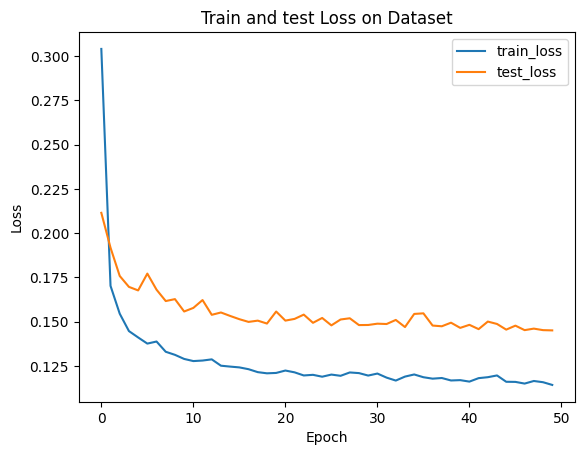

In [13]:
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Train and test Loss on Dataset")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

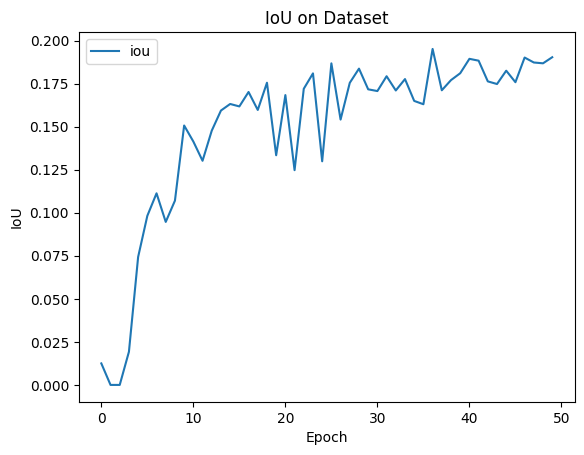

In [14]:
plt.figure()
plt.plot(H["iou"], label="iou")
plt.title("IoU on Dataset")
plt.xlabel("Epoch")
plt.ylabel("IoU")
plt.legend()
plt.show()

In [15]:
model = UNet(nbClasses=1).to(DEVICE)
model.load_state_dict(torch.load(f"{MODEL_SAVED_PATH}unet_epoch_49.pt"))

<All keys matched successfully>

In [16]:
def prepare_plot(origImage, predMask):
    # initialize our figure
    figure, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
    # plot the original image, its mask, and the predicted mask
    ax[0].imshow(origImage)
    
    ax[1].imshow(predMask)
    # set the titles of the subplots
    ax[0].set_title("Image")
    # set the layout of the figure and display it
    figure.tight_layout()
    figure.show()

In [17]:
def make_predictions(model, imagePath):
    # set model to evaluation mode
    model.eval()
    # turn off gradient tracking
    with torch.no_grad():
        # load the image from disk, swap its color channels, cast it
        # to float data type, and scale its pixel values
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image.astype("float32") / 255.0
        # resize the image and make a copy of it for visualization
        image = cv2.resize(image, (256, 256))
        orig = image.copy()
        # find the filename and generate the path to ground truth
        # mask
  
    # make the channel axis to be the leading one, add a batch
        # dimension, create a PyTorch tensor, and flash it to the
        # current device
        image = np.transpose(image, (2, 0, 1))
        image = np.expand_dims(image, 0)
        image = torch.from_numpy(image).to(DEVICE)
        # make the prediction, pass the results through the sigmoid
        # function, and convert the result to a NumPy array
        predMask = model(image).squeeze()
        predMask = torch.sigmoid(predMask)
        predMask = predMask.cpu().numpy()
        # filter out the weak predictions and convert them to integers
        predMask = (predMask > THRESHOLD) * 255

        predMask = predMask.astype(np.uint8)
        # prepare a plot for visualization
        prepare_plot(orig, predMask)

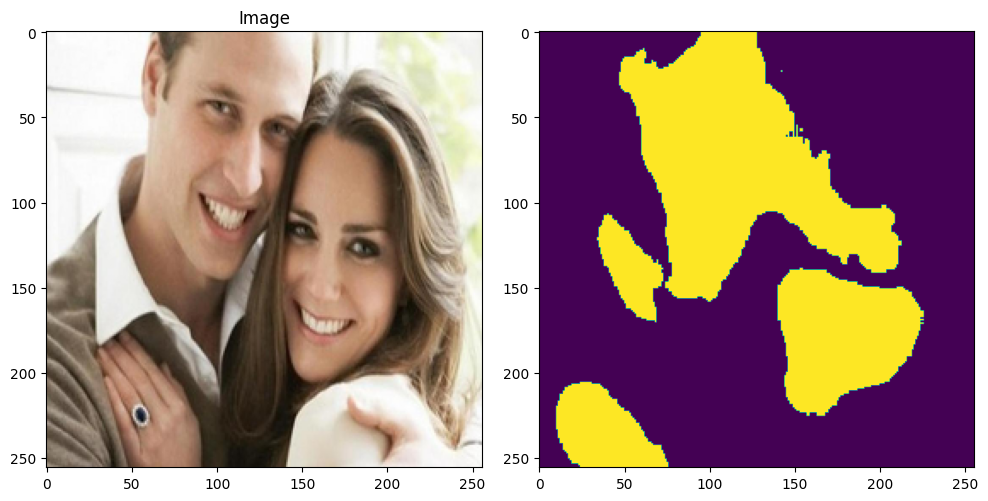

In [18]:
make_predictions(model, f"{DATA_PATH}data/images/19--Couple/19_Couple_Couple_19_630.jpg")